In [44]:
import numpy  as np
import sympy  as sym

import matplotlib.pyplot as plt
import scipy.sparse      as sparse

import utilitis_FEEC.evaluation as eva
import utilitis_FEEC.bsplines   as bsp
import utilitis_FEEC.Bspline    as bspline

import utilitis_FEEC.projections_mhd as mhd
import utilitis_FEEC.projectors_opt  as proj
import utilitis_FEEC.derivatives     as der

import utilitis_FEEC.mass_matrices_stencil as mass

In [45]:
Nel = [3, 3, 128]            # mesh generation on logical domain
bc  = [True, True, True]     # boundary conditions
p   = [2, 2, 3]              # splines degrees




el_b     = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                           # breakpoints
T        = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]       # knot vectors
Nbase    = [(Nel + p) for Nel, p in zip(Nel, p)]                                   # number of basis functions
greville = [(bsp.greville(T, p, bc) + p%2*1e-15) for T, p, bc in zip(T, p, bc)]    # greville points
mapping  = 'cube'                                                                  # geometry






if mapping == 'annulus':
    
    # ... coordinates
    r, phi, z = sym.symbols('r, phi, z')
    q = sym.Matrix([r, phi, z])
    
    # ... mapping
    R1 = 0.2         # inner radius
    R2 = 1.0         # outer radius
    dR = R2 - R1     # thickness
    
    F = sym.Matrix([(r*dR + R1)*sym.cos(2*sym.pi*phi), (r*dR + R1)*sym.sin(2*sym.pi*phi), z])
    
elif mapping == 'torus':
    
    # ... coordinates
    r, theta, phi = sym.symbols('r, theta, phi')
    q = sym.Matrix([r, theta, phi])

    # ... mapping
    R0 = 1.5         # major radius
    R1 = 0.2         # inner radius
    R2 = 1.0         # outer radius
    dR = R2 - R1     # thickness
    
    F = sym.Matrix([(R0 + (r*dR + R1)*sym.cos(2*sym.pi*theta))*sym.cos(2*sym.pi*phi), (R0 + (r*dR + R1)*sym.cos(2*sym.pi*theta))*sym.sin(2*sym.pi*phi), (r*dR + R1)*sym.sin(2*sym.pi*theta)])
    
elif mapping == 'cube':
    
    # ... coordinates
    x, y, z = sym.symbols('x, y, z')
    q = sym.Matrix([x, y, z])
    
    # ... mapping
    Lx = 1.           # length in x
    Ly = 1.           # length in y
    Lz = 20.          # length in z
    
    F = sym.Matrix([Lx*x, Ly*y, Lz*z])
    

# ... jacobian matrix and its inverse
DF    = sym.simplify(F.jacobian(q))
DFinv = DF.inverse()

# ... metric tensor and its inverse
G    = sym.simplify(DF.transpose()*DF)
Ginv = G.inverse()

#... square root of jacobi determinant
g      = sym.simplify(G.det())
g_sqrt = sym.sqrt(g)


# ... convert mapping functions to callables
xc = sym.lambdify(q, F[0])
yc = sym.lambdify(q, F[1])
zc = sym.lambdify(q, F[2])

G      = [[sym.lambdify(q, G[0, 0]), sym.lambdify(q, G[0, 1]), sym.lambdify(q, G[0, 2])], [sym.lambdify(q, G[1, 0]), sym.lambdify(q, G[1, 1]), sym.lambdify(q, G[1, 2])], [sym.lambdify(q, G[2, 0]), sym.lambdify(q, G[2, 1]), sym.lambdify(q, G[2, 2])]]
Ginv   = [[sym.lambdify(q, Ginv[0, 0]), sym.lambdify(q, Ginv[0, 1]), sym.lambdify(q, Ginv[0, 2])], [sym.lambdify(q, Ginv[1, 0]), sym.lambdify(q, Ginv[1, 1]), sym.lambdify(q, Ginv[1, 2])], [sym.lambdify(q, Ginv[2, 0]), sym.lambdify(q, Ginv[2, 1]), sym.lambdify(q, Ginv[2, 2])]]
g      = sym.lambdify(q, g)
g_sqrt = sym.lambdify(q, g_sqrt)



# ... physical input parameters for homogeneous equlibrium (cartesian coordinates!)
rho0 = 1.                     # ... equilibrium mass density of plasma
p0   = 1.                     # ... equilibrium pressure of plasma 
B0x  = 0.                     # ... background magnetic field in x - direction 
B0y  = 0.                     # ... background magnetic field in y - direction
B0z  = 1.                     # ... background magnetic field in z - direction



# ... components of the corresponding differential forms in logical coordinates
rho0_123 = lambda q1, q2, q3 : g_sqrt(0., 0., 0.) * rho0 * np.ones(q1.shape)
#rho0_123 = lambda q1, q2, q3 : g_sqrt(0., 0., 0.) * rho0 * np.cos(2*np.pi*q3)

pr0      = lambda q1, q2, q3 : p0 * np.ones(q1.shape)     

B0_23    = lambda q1, q2, q3 : g_sqrt(0., 0., 0.) * DFinv[0, 0] * B0x * np.ones(q1.shape)  
B0_31    = lambda q1, q2, q3 : g_sqrt(0., 0., 0.) * DFinv[1, 1] * B0y * np.ones(q1.shape)    
B0_12    = lambda q1, q2, q3 : g_sqrt(0., 0., 0.) * DFinv[2, 2] * B0z * np.ones(q1.shape)   

B0_hat   = [B0_23, B0_31, B0_12]

gamma    = 5/3                                        # ... adiabatic exponent
cS       = np.sqrt(gamma*p0/rho0)                     # ... speed of sound
vA       = np.sqrt((B0x**2 + B0y**2 + B0z**2)/rho0)   # ... Alfvén velocity



# ... dispersion relations for magnetosonic waves and shear Alfvén waves
def omegaM(k, pol):
    
    delta = (4*B0z**2*cS**2*vA**2)/((cS**2 + vA**2)**2*(B0x**2 + B0y**2 + B0z**2))
    
    return np.sqrt(1/2*k**2*(cS**2 + vA**2)*(1 + pol*np.sqrt(1 - delta)))

def omegaS(k):
    return vA*k*np.sqrt(B0z/np.sqrt(B0x**2 + B0y**2 + B0z**2))
# ...






# ... initial conditions
amp = 0.1                                             # ... characteristic amplitude of pertubations
kz  = 2                                               # ... wavenumber of initial pertubation
w   = omegaM(kz, +1)                                  # ... frequency of wave
vph = w/kz                                            # ... phase velocity


"""
u1_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)
u2_ini = lambda q1, q2, q3 : amp * np.sin(2*np.pi*kz*q3)
u3_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)

B1_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)
B2_ini = lambda q1, q2, q3 : -kz*B03/w * amp * np.sin(2*np.pi*kz*q3)
B3_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)

rh_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)
pr_ini = lambda q1, q2, q3 : 0 * np.ones(q1.shape)
"""



Nmodes = 128
modesz = np.linspace(0, Nmodes, Nmodes + 1) - Nmodes/2
modesz = np.delete(modesz, int(Nmodes/2))
amps   = np.random.rand(8, Nmodes)



def u1_ini(q1, q2, q3):
    
    values = np.zeros(q1.shape)
    
    for i in range(Nmodes):
        values += amps[0, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values

def u2_ini(q1, q2, q3):
    
    values = np.zeros(q2.shape)
    
    for i in range(Nmodes):
        values += amps[1, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values

def u3_ini(q1, q2, q3):
    
    values = np.zeros(q3.shape)
    
    for i in range(Nmodes):
        values += amps[2, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values



def B1_ini(q1, q2, q3):
    
    values = np.zeros(q2.shape)
    
    for i in range(Nmodes):
        values += amps[3, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values

def B2_ini(q1, q2, q3):
    
    values = np.zeros(q1.shape)
    
    for i in range(Nmodes):
        values += amps[4, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values

def B3_ini(q1, q2, q3):
    
    values = np.zeros(q1.shape)
    
    for i in range(Nmodes):
        values += 0*np.sin(2*np.pi*modesz[i]*q3)
        
    return values


def rh_ini(q1, q2, q3):
    
    values = np.zeros(q1.shape)
    
    for i in range(Nmodes):
        values += amps[6, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values


def pr_ini(q1, q2, q3):
    
    values = 0.
    
    for i in range(Nmodes):
        values += amps[7, i]*np.sin(2*np.pi*modesz[i]*q3)
        
    return values

In [46]:
vFast  = omegaM(2, +1)/2
vSlow  = omegaM(2, -1)/2
vShear = omegaS(2)/2

In [47]:
vFast

1.2909944487358056

In [48]:
MHD = mhd.projections_mhd(p, Nbase, T, bc)

In [49]:
# right-hand sides of projection matrices
Q1, Q2, Q3 = MHD.projection_Q(rho0_123, Ginv)

W1, W2, W3 = MHD.projection_W(rho0_123, g_sqrt)
T1, T2, T3 = MHD.projection_T(B0_hat, Ginv)

L1, L2, L3 = MHD.projection_L(g_sqrt, G)
Y1, Y2, Y3 = MHD.projection_Y(g_sqrt, Ginv)

In [8]:
# left-hand sides of projectors
PRO = proj.projectors_3d(p, Nbase, T, bc)

PRO.assemble_V0()
PRO.assemble_V1()
PRO.assemble_V2()
PRO.assemble_V3()

In [9]:
# mass matrices and spaces in V0, V1 and V2
M0     = mass.mass_matrix_V0(p, Nbase, T, g_sqrt, bc)
M1, V1 = mass.mass_matrix_V1(p, Nbase, T, Ginv, g_sqrt, bc)
M2, V2 = mass.mass_matrix_V2(p, Nbase, T, G, g_sqrt, bc)

In [10]:
# block matrices
from psydac.linalg.block import BlockMatrix

M0 = M0.tosparse().tocsc()
M1 = BlockMatrix(V1, V1, blocks=M1).tosparse().tocsc()
M2 = BlockMatrix(V2, V2, blocks=M2).tosparse().tocsc()

In [11]:
# discrete grad, curl and div
GRAD = der.GRAD_3d(p, Nbase, bc)
CURL = der.CURL_3d(p, Nbase, bc)
DIV  = der.DIV_3d(p, Nbase, bc)

In [12]:
# inverse of M0 and M1
M0inv = sparse.linalg.inv(M0)
M1inv = sparse.linalg.inv(M1)

# 1. Shear Alfvén waves

In [13]:
# perform projections of T
T1 = sparse.linalg.spsolve(PRO.interhistopolation_V1_1, T1)
T2 = sparse.linalg.spsolve(PRO.interhistopolation_V1_2, T2)
T3 = sparse.linalg.spsolve(PRO.interhistopolation_V1_3, T3)

In [14]:
# block matrices
T = sparse.bmat([[T1], [T2], [T3]], format='csc')

In [15]:
# time step
dt = 0.05

In [16]:
# update using Crank-Nicolson
mat1 = sparse.bmat([[None, M1inv.dot(T.T.dot(CURL.T.dot(M2)))/rho0], [-CURL.dot(T), None]], format='csc')

N = Nel[0]*Nel[1]*Nel[2]

mat1_LU = sparse.linalg.splu(sparse.identity(6*N, format='csc') - dt/2*mat1)
mat2 = sparse.identity(6*N, format='csc') + dt/2*mat1

def update_CrankNicolson(u_vec, b_vec):
    
    S = np.concatenate((u_vec, b_vec))
    
    Snew = mat1_LU.solve(mat2.dot(S))
    
    unew   = Snew[:3*N]
    bnew   = Snew[3*N:]
    
    return unew, bnew

In [17]:
# update using Hamiltonian splitting (Lie_Trotter)
A1 = CURL.dot(T)
A2 = M1inv.dot(T.T.dot(CURL.T.dot(M2)))/rho0


def update_Hamiltonian_Lie(u_vec, b_vec):
    
    bnew = b_vec - dt*A1.dot(u_vec)
    unew = u_vec + dt*A2.dot(bnew)
    
    return unew, bnew

In [18]:
# update using Hamiltonian splitting (Strang)
A1 = CURL.dot(T)
A2 = M1inv.dot(T.T.dot(CURL.T.dot(M2)))/rho0


def update_Hamiltonian_Strang(u_vec, b_vec):
    
    bnew = b_vec - dt/2*A1.dot(u_vec)
    
    unew = u_vec + dt*A2.dot(bnew)
    
    bnew = bnew  - dt/2*A1.dot(unew)
    
    return unew, bnew

In [19]:
# update using Hamiltonian splitting (4th order)
A1 = CURL.dot(T)
A2 = M1inv.dot(T.T.dot(CURL.T.dot(M2)))/rho0

a1 = (146 + 5*np.sqrt(19))/540
a2 = (-2 + 10*np.sqrt(19))/135
a3 = 1/5
a4 = (-23 - 20*np.sqrt(19))/270
a5 = (14 - np.sqrt(19))/108


def update_Hamiltonian_4th(u_vec, b_vec):
    
    
    bnew = b_vec - a5*dt*A1.dot(u_vec)
    unew = u_vec + a5*dt*A2.dot(bnew)
    
    unew = unew  + a1*dt*A2.dot(bnew)
    bnew = bnew  - a1*dt*A1.dot(unew)
    
    bnew = bnew  - a4*dt*A1.dot(unew)
    unew = unew  + a4*dt*A2.dot(bnew)
    
    unew = unew  + a2*dt*A2.dot(bnew)
    bnew = bnew  - a2*dt*A1.dot(unew)
    
    bnew = bnew  - a3*dt*A1.dot(unew)
    unew = unew  + a3*dt*A2.dot(bnew)
    
    unew = unew  + a3*dt*A2.dot(bnew)
    bnew = bnew  - a3*dt*A1.dot(unew)
    
    bnew = bnew  - a2*dt*A1.dot(unew)
    unew = unew  + a2*dt*A2.dot(bnew)
    
    unew = unew  + a4*dt*A2.dot(bnew)
    bnew = bnew  - a4*dt*A1.dot(unew)
    
    bnew = bnew  - a1*dt*A1.dot(unew)
    unew = unew  + a1*dt*A2.dot(bnew)
    
    unew = unew  + a5*dt*A2.dot(bnew)
    bnew = bnew  - a5*dt*A1.dot(unew)
    
    return unew, bnew

In [27]:
# projection of initial conditions
u1_vec, u2_vec, u3_vec = PRO.PI_1([u1_ini, u2_ini, u3_ini])
b1_vec, b2_vec, b3_vec = PRO.PI_2([B1_ini, B2_ini, B3_ini])

In [28]:
u_vec = np.concatenate((u1_vec, u2_vec, u3_vec))
b_vec = np.concatenate((b1_vec, b2_vec, b3_vec))

S = np.concatenate((u_vec, b_vec))
H = 1/2*rho0*np.dot(u_vec, M1.dot(u_vec)) + 1/2*np.dot(b_vec, M2.dot(b_vec))

## 1. 1 Crank-Nicolson

In [29]:
# time integration (Crank-Nicolson)
Nt = 400
T  = Nt*dt

for i in range(Nt):
    u_vec, b_vec = update_CrankNicolson(u_vec, b_vec)
    
    S = np.vstack((S, np.concatenate((u_vec, b_vec))))
    H = np.append(H, 1/2*rho0*np.dot(u_vec, M1.dot(u_vec)) + 1/2*np.dot(b_vec, M2.dot(b_vec)))

In [30]:
w = np.linspace(0, Nt, Nt + 1) - Nt/2
w = 2*np.pi/T*w

k = np.linspace(0, Nel[2], Nel[2] + 1) - Nel[2]/2
k = 2*np.pi/Lz*k

In [31]:
uy = S[:, 1*N:2*N]
uy = np.reshape(uy, (Nt + 1, Nel[0], Nel[1], Nel[2]))

In [32]:
uykw = np.fft.fft2(np.c_[uy[:, 1, 1, :], uy[:, 1, 1, 0]])
K, W = np.meshgrid(k, w)
uykw = np.fft.fftshift(uykw)
uykw_plot = np.abs(uykw)

Text(0,0.5,'w')

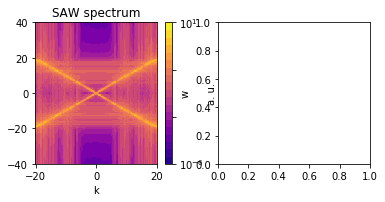

In [43]:
from matplotlib.colors import LogNorm

fn, ((ax1, ax2)) = plt.subplots(1, 2)
fn.set_figheight(2.6)
fn.set_figwidth(6)

lvls = np.logspace(-6, 1, 20)
cont1 = ax1.contourf(K, W, uykw_plot/uykw_plot.max(), cmap = 'plasma', norm = LogNorm(), levels=lvls)
ax1.set_title('SAW spectrum')
ax1.set_ylim((-40, 40))
ticks = np.power(10, np.linspace(-6, 1, 4))
plt.colorbar(mappable=cont1, ax=ax1, ticks=ticks, label=r'a. u.')
ax1.set_xlabel('k')
ax2.set_ylabel('w')

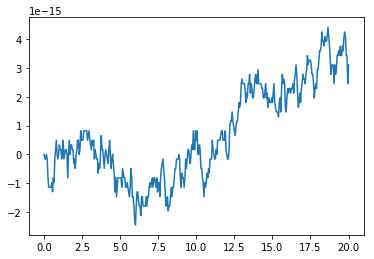

In [40]:
plt.plot(np.linspace(0., T, Nt + 1), (H - H[0])/H[0])

## 1. 2 Hamiltonian splitting: Lie-Trotter

In [245]:
# time integration (Hamiltonian splitting: Lie-Trotter)
Nt = 400
TT = Nt*dt

for i in range(Nt):
    u_vec, b_vec = update_Hamiltonian_Lie(u_vec, b_vec)
    
    S = np.vstack((S, np.concatenate((u_vec, b_vec))))
    H = np.append(H, 1/2*rho0*np.dot(u_vec, M1.dot(u_vec)) + 1/2*np.dot(b_vec, M2.dot(b_vec)))

In [247]:
w = np.linspace(0, Nt, Nt + 1) - Nt/2
w = 2*np.pi/TT*w

k = np.linspace(0, Nel[2], Nel[2] + 1) - Nel[2]/2
k = 2*np.pi/Lz*k

In [248]:
N = Nel[0]*Nel[1]*Nel[2]

uy = S[:, 1*N:2*N]
uy = np.reshape(uy, (Nt + 1, Nel[0], Nel[1], Nel[2]))

In [249]:
uykw = np.fft.fft2(np.c_[uy[:, 1, 1, :], uy[:, 1, 1, 0]])
K, W = np.meshgrid(k, w)
uykw = np.fft.fftshift(uykw)
uykw_plot = np.abs(uykw)

Text(0,0.5,'w')

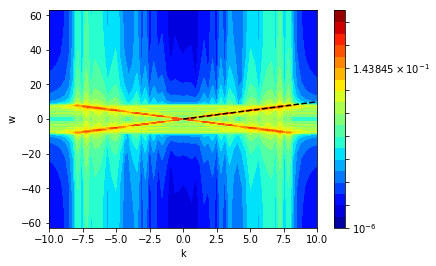

In [250]:
from matplotlib.colors import LogNorm

lvls = np.logspace(-6, 1, 20)
plt.contourf(K, W, uykw_plot/uykw_plot.max(), cmap = 'jet', norm = LogNorm(), levels=lvls)

plt.plot(np.linspace(0, 10, 50), vShear*np.linspace(0, 10, 50), 'k--')
plt.xlim((-10, 10))

plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')

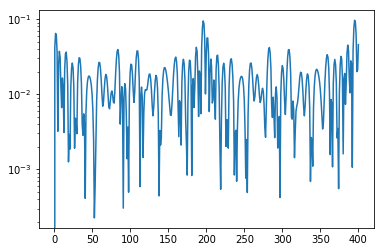

In [251]:
plt.semilogy(np.abs(H - H[0])/H[0])

## 1. 3 Hamiltonian splitting: Strang

In [256]:
# time integration (Hamiltonian splitting: Strang)
Nt = 400
TT = Nt*dt

for i in range(Nt):
    u_vec, b_vec = update_Hamiltonian_Strang(u_vec, b_vec)
    
    S = np.vstack((S, np.concatenate((u_vec, b_vec))))
    H = np.append(H, 1/2*rho0*np.dot(u_vec, M1.dot(u_vec)) + 1/2*np.dot(b_vec, M2.dot(b_vec)))

In [258]:
w = np.linspace(0, Nt, Nt + 1) - Nt/2
w = 2*np.pi/TT*w

k = np.linspace(0, Nel[2], Nel[2] + 1) - Nel[2]/2
k = 2*np.pi/Lz*k

In [259]:
N = Nel[0]*Nel[1]*Nel[2]

uy = S[:, 1*N:2*N]
uy = np.reshape(uy, (Nt + 1, Nel[0], Nel[1], Nel[2]))

In [260]:
uykw = np.fft.fft2(np.c_[uy[:, 1, 1, :], uy[:, 1, 1, 0]])
K, W = np.meshgrid(k, w)
uykw = np.fft.fftshift(uykw)
uykw_plot = np.abs(uykw)

Text(0,0.5,'w')

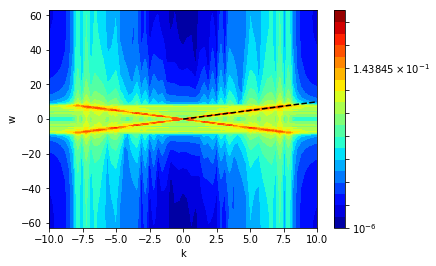

In [261]:
from matplotlib.colors import LogNorm

lvls = np.logspace(-6, 1, 20)
plt.contourf(K, W, uykw_plot/uykw_plot.max(), cmap = 'jet', norm = LogNorm(), levels=lvls)

plt.plot(np.linspace(0, 10, 50), vShear*np.linspace(0, 10, 50), 'k--')
plt.xlim((-10, 10))

plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')

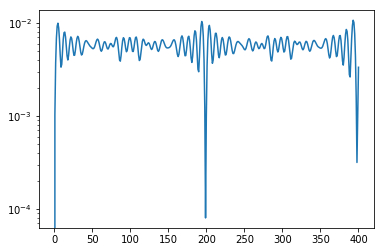

In [262]:
plt.semilogy(np.abs(H - H[0])/H[0])

## Hamiltonian splitting: 4th order

In [267]:
# time integration (Hamiltonian splitting: 4th order)
Nt = 400
TT = Nt*dt

for i in range(Nt):
    u_vec, b_vec = update_Hamiltonian_4th(u_vec, b_vec)
    
    S = np.vstack((S, np.concatenate((u_vec, b_vec))))
    H = np.append(H, 1/2*rho0*np.dot(u_vec, M1.dot(u_vec)) + 1/2*np.dot(b_vec, M2.dot(b_vec)))

In [269]:
w = np.linspace(0, Nt, Nt + 1) - Nt/2
w = 2*np.pi/TT*w

k = np.linspace(0, Nel[2], Nel[2] + 1) - Nel[2]/2
k = 2*np.pi/Lz*k

In [270]:
N = Nel[0]*Nel[1]*Nel[2]

uy = S[:, 1*N:2*N]
uy = np.reshape(uy, (Nt + 1, Nel[0], Nel[1], Nel[2]))

In [271]:
uykw = np.fft.fft2(np.c_[uy[:, 1, 1, :], uy[:, 1, 1, 0]])
K, W = np.meshgrid(k, w)
uykw = np.fft.fftshift(uykw)
uykw_plot = np.abs(uykw)

Text(0,0.5,'w')

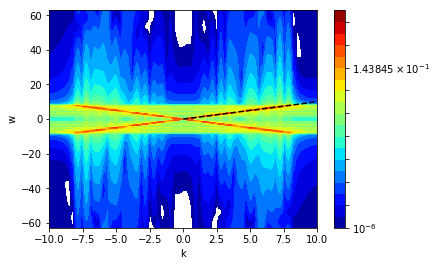

In [272]:
from matplotlib.colors import LogNorm

lvls = np.logspace(-6, 1, 20)
plt.contourf(K, W, uykw_plot/uykw_plot.max(), cmap = 'jet', norm = LogNorm(), levels=lvls)

plt.plot(np.linspace(0, 10, 50), vShear*np.linspace(0, 10, 50), 'k--')
plt.xlim((-10, 10))

plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')

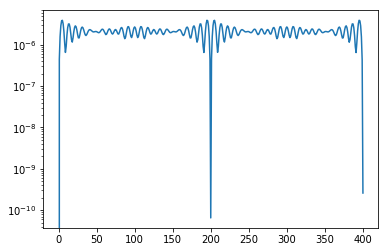

In [273]:
plt.semilogy(np.abs(H - H[0])/H[0])

# 2. Full system

In [302]:
# Perform projections of Q
Q1 = sparse.linalg.spsolve(PRO.interhistopolation_V2_1, Q1)
Q2 = sparse.linalg.spsolve(PRO.interhistopolation_V2_2, Q2)
Q3 = sparse.linalg.spsolve(PRO.interhistopolation_V2_3, Q3)

In [303]:
# Perform projections of T
T1 = sparse.linalg.spsolve(PRO.interhistopolation_V1_1, T1)
T2 = sparse.linalg.spsolve(PRO.interhistopolation_V1_2, T2)
T3 = sparse.linalg.spsolve(PRO.interhistopolation_V1_3, T3)

In [304]:
# block matrices
Q = sparse.bmat([[Q1], [Q2], [Q3]], format='csc')
T = sparse.bmat([[T1], [T2], [T3]], format='csc')

In [305]:
# system matrix
mat1 = sparse.bmat([[sparse.csr_matrix((Nel[0]*Nel[1]*Nel[2], Nel[0]*Nel[1]*Nel[2])), -DIV.dot(Q), None, None], [None, None, M1inv.dot(T.T.dot(CURL.T.dot(M2)))/rho0, -GRAD/rho0], [None, -CURL.dot(T), None, None], [None, p0*gamma*M0inv.dot(GRAD.T.dot(M1)), None, None]], format='csc')

In [306]:
# LU factorization of implicit part
dt = 0.05
N = Nel[0]*Nel[1]*Nel[2]

mat1_LU = sparse.linalg.splu(sparse.identity(8*N, format='csc') - dt/2*mat1)

In [307]:
# Explicit part
mat2 = sparse.identity(8*N, format='csc') + dt/2*mat1

In [308]:
def update(rho_vec, u_vec, b_vec, p_vec):
    
    S = np.concatenate((rho_vec, u_vec, b_vec, p_vec))
    
    Snew = mat1_LU.solve(mat2.dot(S))
    
    rhonew = Snew[0:N]
    unew   = Snew[N:4*N]
    bnew   = Snew[4*N:7*N]
    pnew   = Snew[7*N:8*N]
    
    return rhonew, unew, bnew, pnew

In [309]:
# projection of initial conditions
p_vec                  = PRO.PI_0(pr_ini)
u1_vec, u2_vec, u3_vec = PRO.PI_1([u1_ini, u2_ini, u3_ini])
b1_vec, b2_vec, b3_vec = PRO.PI_2([B1_ini, B2_ini, B3_ini])
rho_vec                = PRO.PI_3(rh_ini)

In [310]:
u_vec = np.concatenate((u1_vec, u2_vec, u3_vec))
b_vec = np.concatenate((b1_vec, b2_vec, b3_vec))

S = np.concatenate((rho_vec, u_vec, b_vec, p_vec))

In [311]:
# time integration
Nt = 400
T = Nt*dt

for i in range(Nt):
    rho_vec, u_vec, b_vec, p_vec = update(rho_vec, u_vec, b_vec, p_vec)
    
    S = np.vstack((S, np.concatenate((rho_vec, u_vec, b_vec, p_vec))))

In [312]:
w = np.linspace(0, Nt, Nt + 1) - Nt/2
w = 2*np.pi/T*w

k = np.linspace(0, Nel[2], Nel[2] + 1) - Nel[2]/2
k = 2*np.pi/Lz*k

In [313]:
uy = S[:, 2*N:3*N]
uy = np.reshape(uy, (Nt + 1, Nel[0], Nel[1], Nel[2]))

In [314]:
uykw = np.fft.fft2(np.c_[uy[:, 1, 1, :], uy[:, 1, 1, 0]])
K, W = np.meshgrid(k, w)
uykw = np.fft.fftshift(uykw)
uykw_plot = np.abs(uykw)

Text(0,0.5,'w')

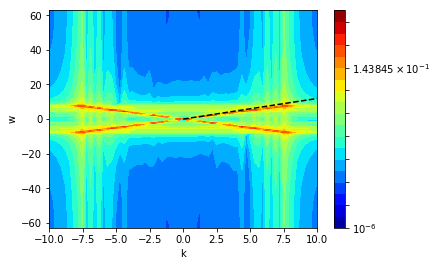

In [315]:
from matplotlib.colors import LogNorm

lvls = np.logspace(-6, 1, 20)
plt.contourf(K, W, uykw_plot/uykw_plot.max(), cmap = 'jet', norm = LogNorm(), levels=lvls)

plt.plot(np.linspace(0, 10, 50), vShear*np.linspace(0, 10, 50), 'k--')
plt.xlim((-10, 10))

plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')

In [316]:
vShear

1.189207115002721

In [317]:
pre = S[:, 7*N:8*N]
pre = np.reshape(pre, (Nt + 1, Nel[0], Nel[1], Nel[2]))

In [318]:
prekw = np.fft.fft2(np.c_[pre[:, 1, 1, :], pre[:, 1, 1, 0]])
K, W = np.meshgrid(k, w)
prekw = np.fft.fftshift(prekw)
prekw_plot = np.abs(prekw)

Text(0,0.5,'w')

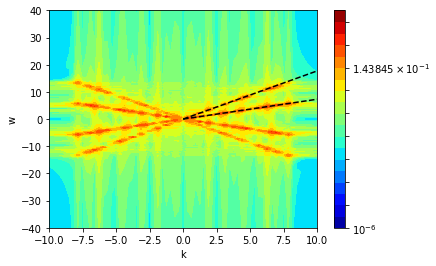

In [319]:
from matplotlib.colors import LogNorm

lvls = np.logspace(-6, 1, 20)
plt.contourf(K, W, prekw_plot/prekw_plot.max(), cmap = 'jet', norm = LogNorm(), levels=lvls)

plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), 'k--')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), 'k--')
plt.xlim((-10, 10))
plt.ylim((-40, 40))

plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')

In [320]:
vSlow

0.7291262263940022